# Explore here

In [1]:
#Importamos Librerias Necesarias
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import *
from imblearn.metrics import specificity_score

# EDA

In [2]:
# Cargamos el dataset
df = pd.read_csv('../data/raw/diabetes.csv')

# Visualizamos los datos
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Visualizamos las Estadísticas Descriptivas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [4]:
# Visualizamos la informacion de la Dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
# Verificamos si existen datos únicos
n_unicos = df.nunique()
n_unicos

Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64

In [6]:
# Revisamos que no tengamos datos duplicados
df.duplicated().sum()

0

In [7]:
# Verificamos los datos nulos o faltantes
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

<Axes: >

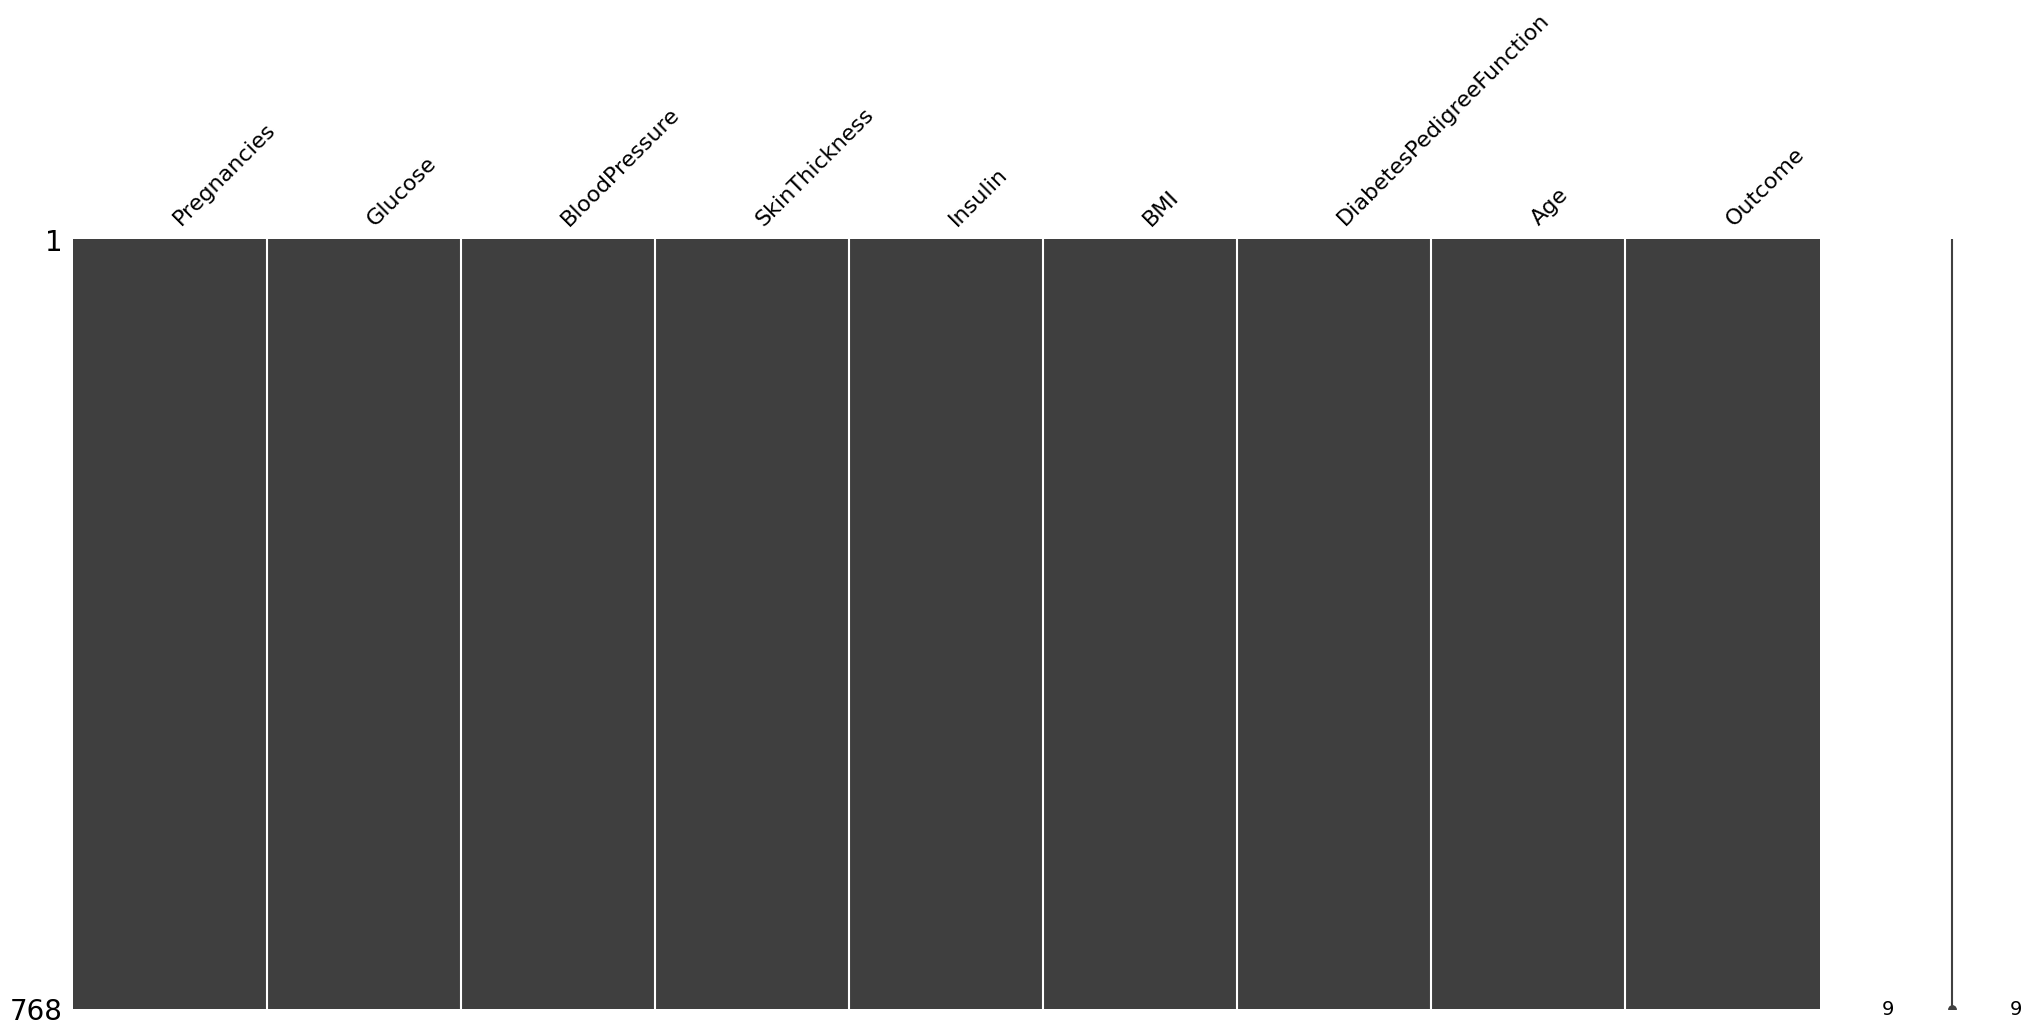

In [8]:
msno.matrix(df)

Se anexa un archivo '../data/raw/Info.txt' con información del significado de los valores del datasets

In [9]:
# Columnas donde los ceros no son válidos
columnas_criticas = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Eliminar filas donde alguna columna crítica tenga valor 0
df_cleaned = df[(df[columnas_criticas] != 0).all(axis=1)]

In [10]:
# Tamaño de la data limpia
df_cleaned.shape

(392, 9)

In [11]:
# Tamaño de la data original
df.shape

(768, 9)

Debido a la pérdida de datos se procede a realizar esta verificación de datos de otra forma.

Se evalúa el cambio del shape al eliminar los datos no válidos individualmente

In [12]:
# Análisis individual por columna
print("\nEliminación individual por columna:")
for col in columnas_criticas:
    temp_df = df[df[col] != 0] # Dataframe temporal sin ceros
    perdida = df.shape[0] - temp_df.shape[0] # Cálculo de filas eliminadas
    print(f"{col}:")
    print(f"  • Filas restantes: {temp_df.shape[0]} ({perdida} filas eliminadas)")
    print(f"  • Pérdida de datos: {perdida/df.shape[0]:.1%}\n")


Eliminación individual por columna:
Glucose:
  • Filas restantes: 763 (5 filas eliminadas)
  • Pérdida de datos: 0.7%

BloodPressure:
  • Filas restantes: 733 (35 filas eliminadas)
  • Pérdida de datos: 4.6%

SkinThickness:
  • Filas restantes: 541 (227 filas eliminadas)
  • Pérdida de datos: 29.6%

Insulin:
  • Filas restantes: 394 (374 filas eliminadas)
  • Pérdida de datos: 48.7%

BMI:
  • Filas restantes: 757 (11 filas eliminadas)
  • Pérdida de datos: 1.4%



Basado en estos resultados y las estadísticas descriptivas, la estrategia a seguir sería:

Eliminar ceros en columnas con baja pérdida de datos (Glucose, BloodPressure, BMI).

Imputar en las de alta pérdida (SkinThickness, Insulin) con la mediana, debido a la alta falta de valores

In [13]:
# Eliminar filas con ceros en columnas de baja pérdida de datos
df_optimo = df[
    (df['Glucose'] != 0) & 
    (df['BloodPressure'] != 0) & 
    (df['BMI'] != 0)].copy()

In [14]:

# Imputar ceros en columnas de alta pérdida usando mediana
columnas_imputar = ['SkinThickness', 'Insulin']

# Calcular medianas evitando ceros (del df ya filtrado)
medianas = {
    'SkinThickness': df_optimo[df_optimo['SkinThickness'] != 0]['SkinThickness'].median(),
    'Insulin': df_optimo[df_optimo['Insulin'] != 0]['Insulin'].median()
}
for col in ['SkinThickness', 'Insulin']:
    #mediana = df_optimo[col].median()
    df_optimo[col] = df_optimo[col].replace(0, medianas[col])


# Imputar ceros de forma segura
#for col in columnas_imputar:
#    df_optimo[col] = df_optimo.loc[df_optimo[col] == 0, col] = medianas[col]

# Ver resultados
print(f"\nFilas finales: {df_optimo.shape}")
print(df_optimo[columnas_criticas].describe())


Filas finales: (724, 9)
          Glucose  BloodPressure  SkinThickness     Insulin         BMI
count  724.000000     724.000000     724.000000  724.000000  724.000000
mean   121.882597      72.400552      29.133978  142.044199   32.467127
std     30.750030      12.379870       9.019267   88.713438    6.888941
min     44.000000      24.000000       7.000000   14.000000   18.200000
25%     99.750000      64.000000      25.000000  118.250000   27.500000
50%    117.000000      72.000000      29.000000  125.500000   32.400000
75%    142.000000      80.000000      33.000000  130.500000   36.600000
max    199.000000     122.000000      99.000000  846.000000   67.100000


In [ ]:
# Verificamos que no existan datos nulos
df_optimo.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [ ]:
# Guardamos data limpia
df_optimo.to_csv("../data/processed/df_clean.csv", index = False)

# Visualizacion

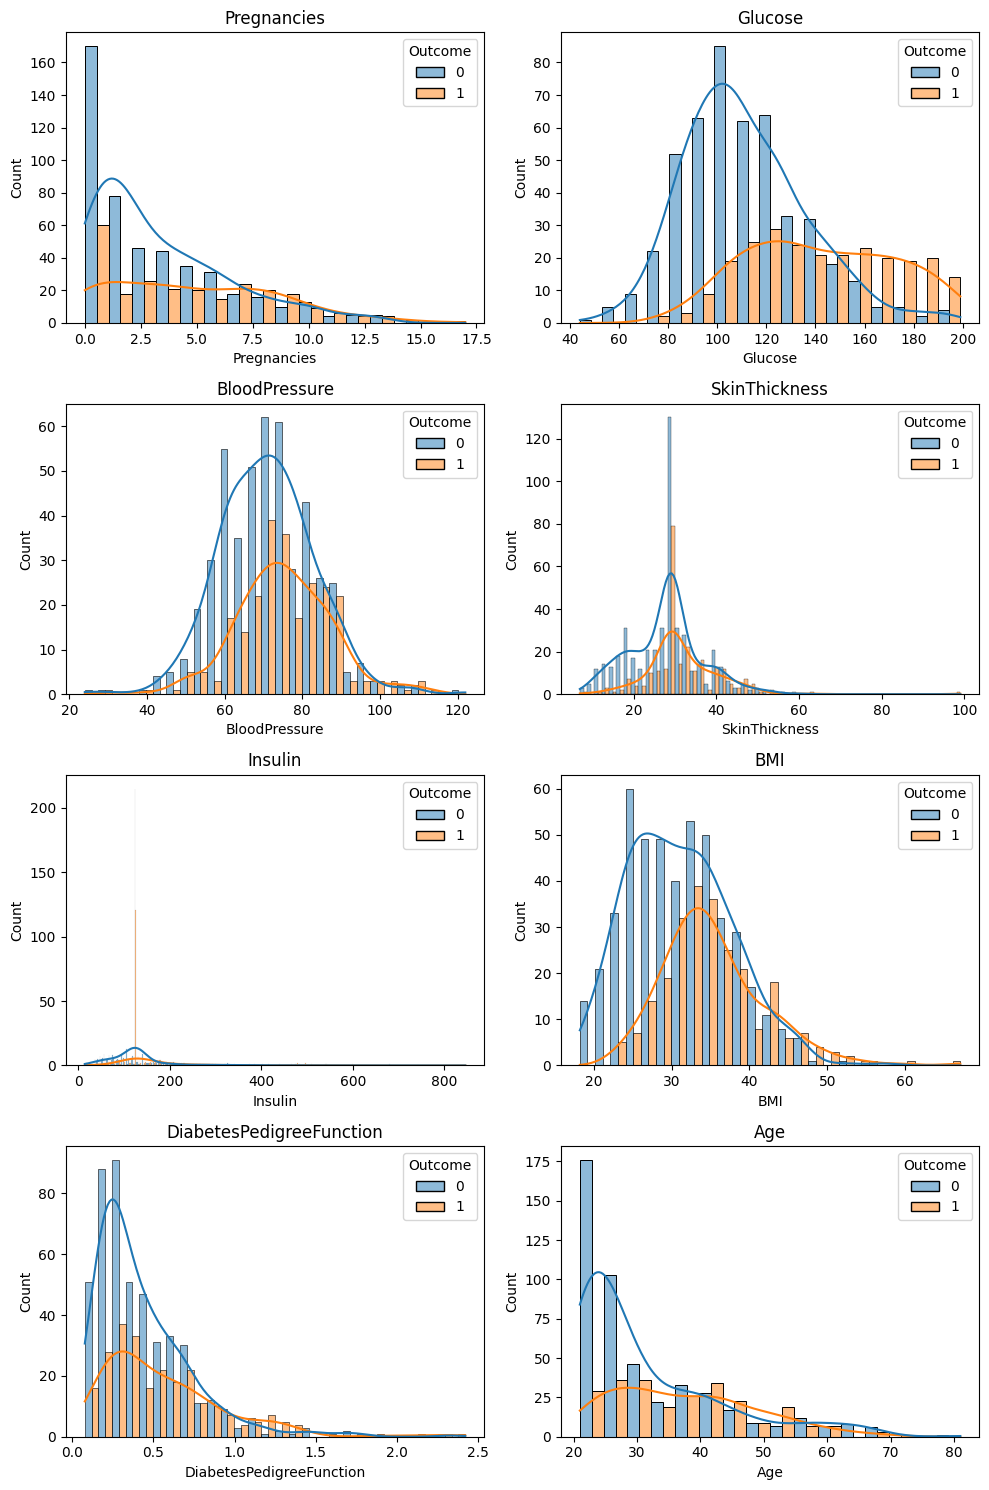

In [17]:
# Seleccinamos las columnas a graficar
columnas = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Creamos hisplot para cada una
fig, axes = plt.subplots(4, 2, figsize=(10, 15))
axes = axes.flatten()  # Convertimos los ejes en una lista plana para iterar

# Iteramos por cada columna del dataframe
for i, columna in enumerate(columnas):
    sns.histplot(ax=axes[i], x=columna, data=df_optimo, hue='Outcome', kde=True, multiple='dodge')  
    axes[i].set_title(columna)

# Para mostrar el gráfico
plt.tight_layout()
plt.show()

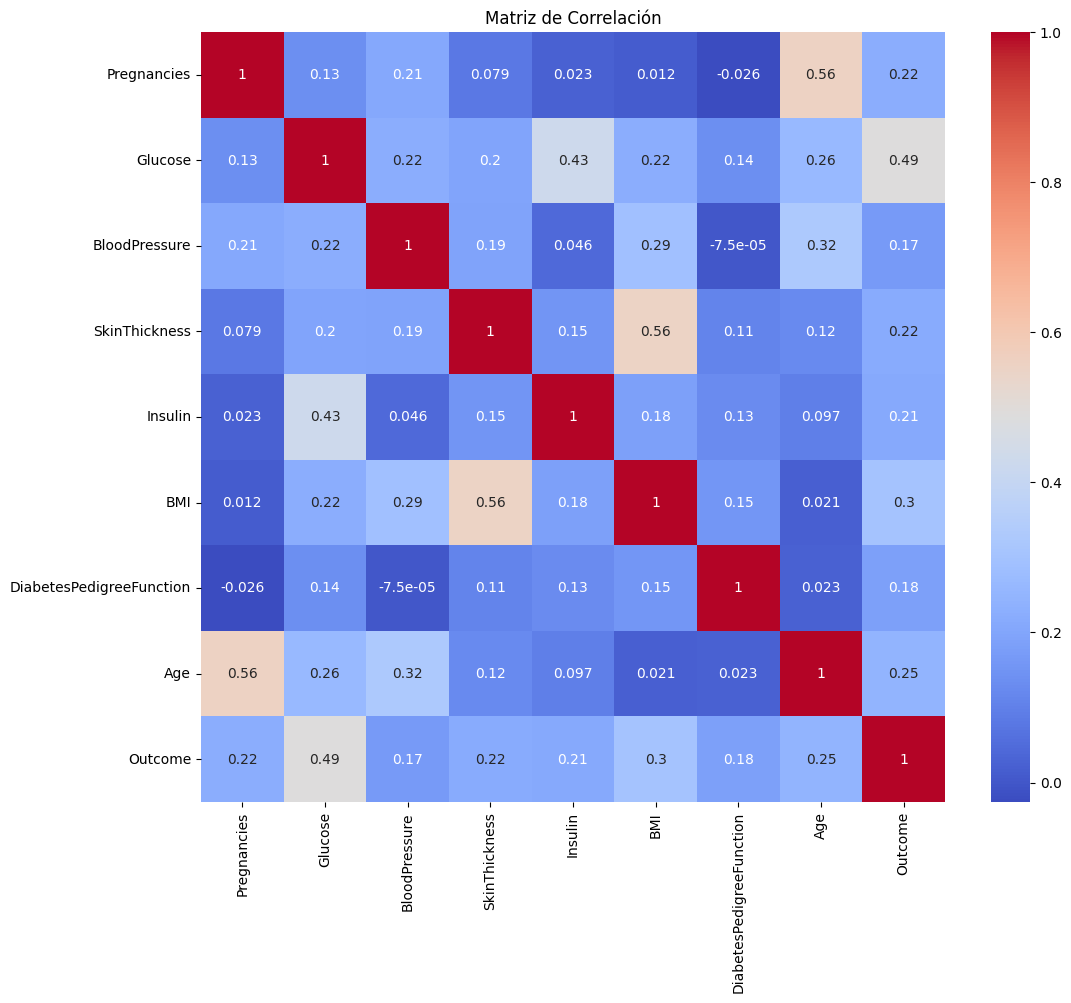

In [18]:
# Matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(df_optimo.corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

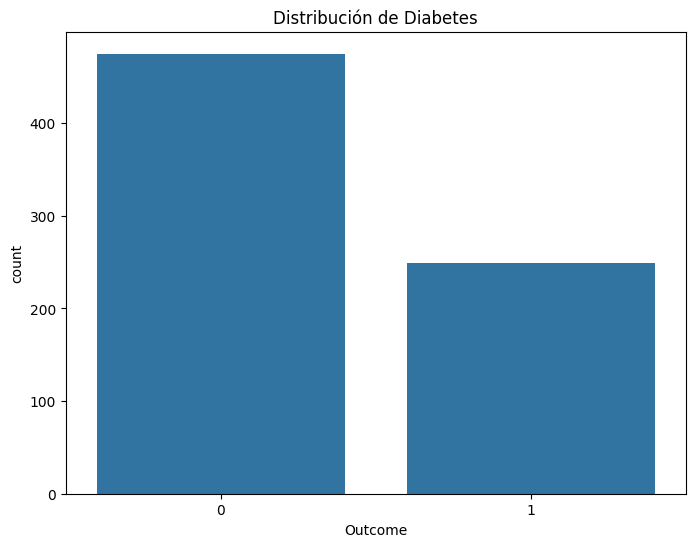

In [19]:
# Distribución de la variable objetivo
plt.figure(figsize=(8, 6))
sns.countplot(x='Outcome', data=df_optimo)
plt.title('Distribución de Diabetes')
plt.show()

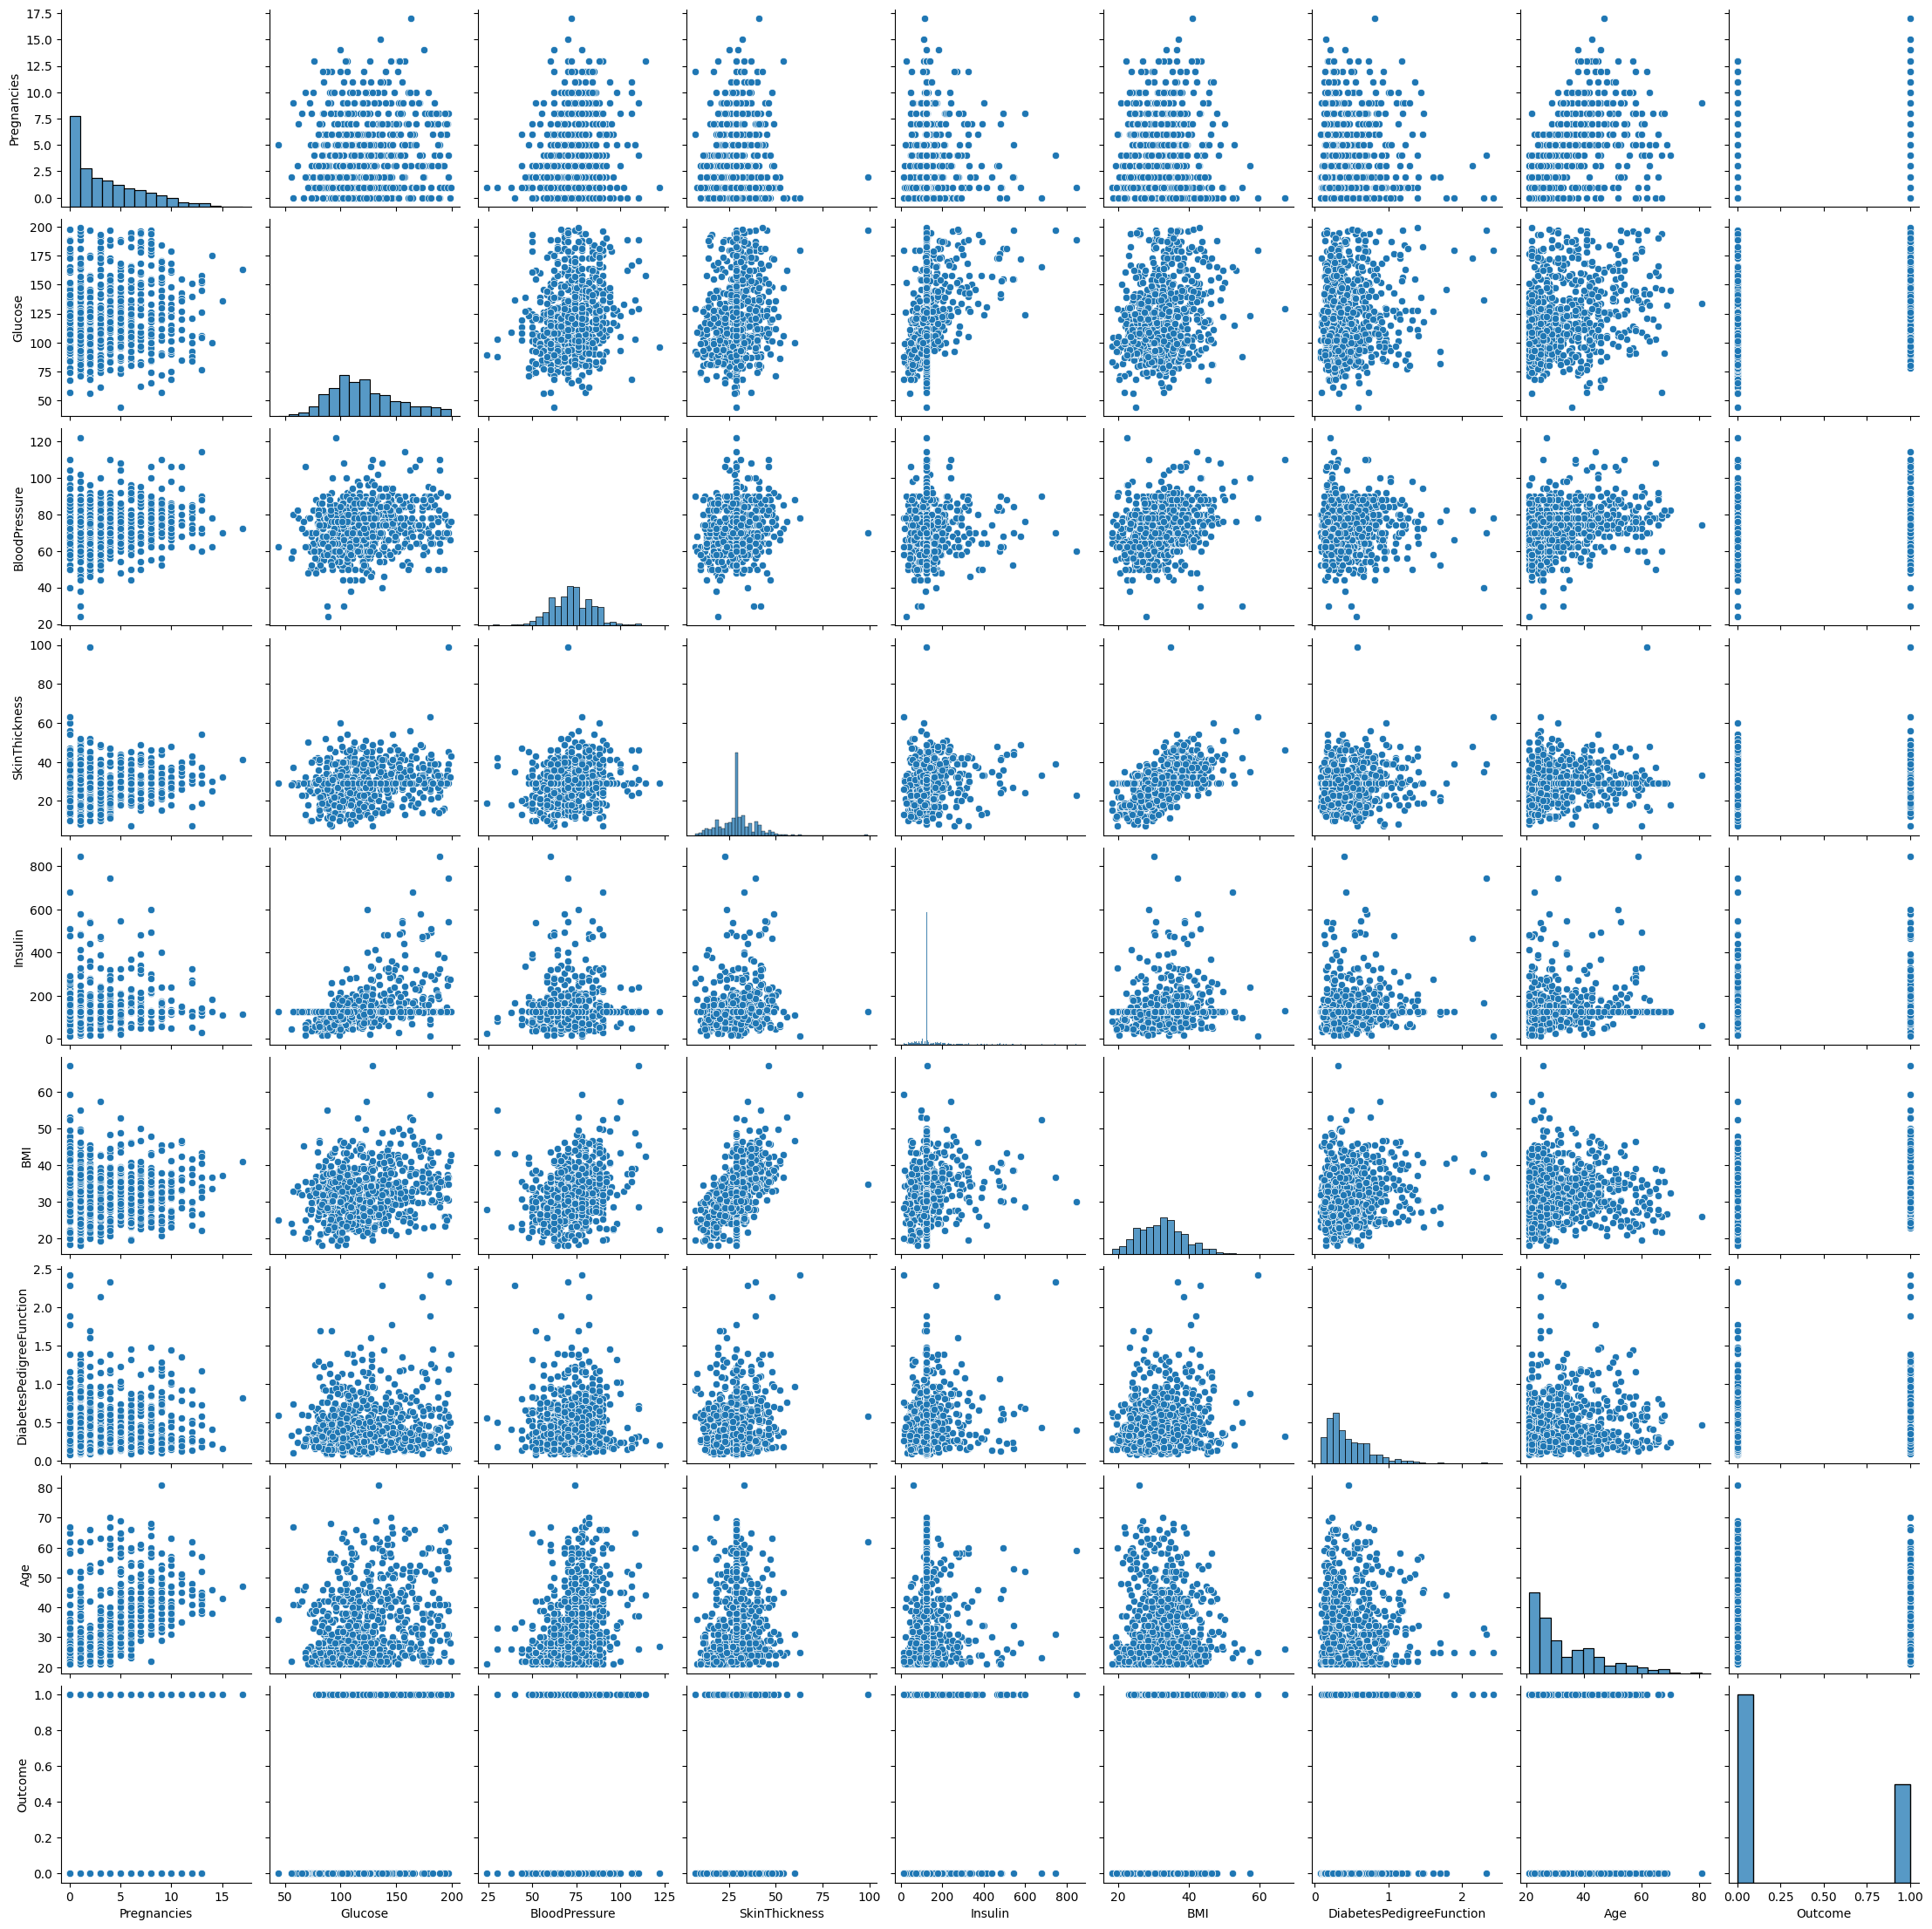

In [20]:
# Realizamos un pairplot
sns.pairplot(df_optimo)

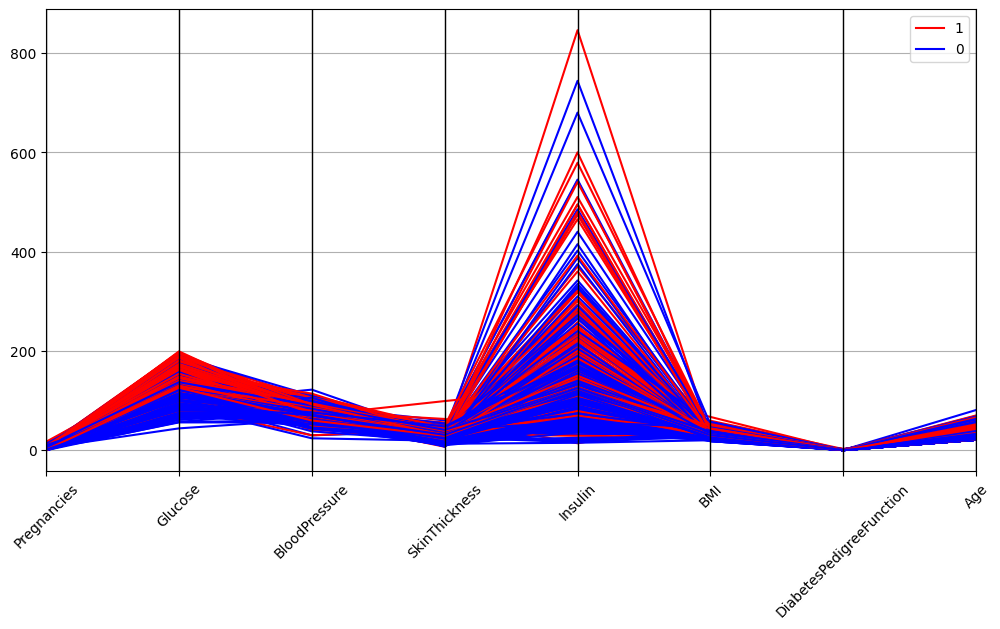

In [21]:
# Creamos un gráfico de coordenadas paralelas para visualizar las características
plt.figure(figsize=(12, 6))
pd.plotting.parallel_coordinates(df_optimo, 'Outcome', color=['red', 'blue'])
plt.xticks(rotation=45)
plt.show()

# Escalado de Datos

In [22]:
# Escalamos las variables para normalizar los datos
scaler = RobustScaler()
scal_variable = scaler.fit_transform(df_optimo)
df1 = pd.DataFrame(scal_variable, index = df_optimo.index, columns = df_optimo.columns)
df1.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.6,0.733728,0.000,0.75,0.000000,0.131868,0.648366,1.235294,1.0
1,-0.4,-0.757396,-0.375,0.00,0.000000,-0.637363,-0.073203,0.117647,0.0
2,1.0,1.562130,-0.500,0.00,0.000000,-1.000000,0.766013,0.176471,1.0
3,-0.4,-0.662722,-0.375,-0.75,-2.571429,-0.472527,-0.554248,-0.470588,0.0
4,-0.6,0.473373,-2.000,0.75,3.469388,1.175824,4.990850,0.235294,1.0


Histograma de datos escalados

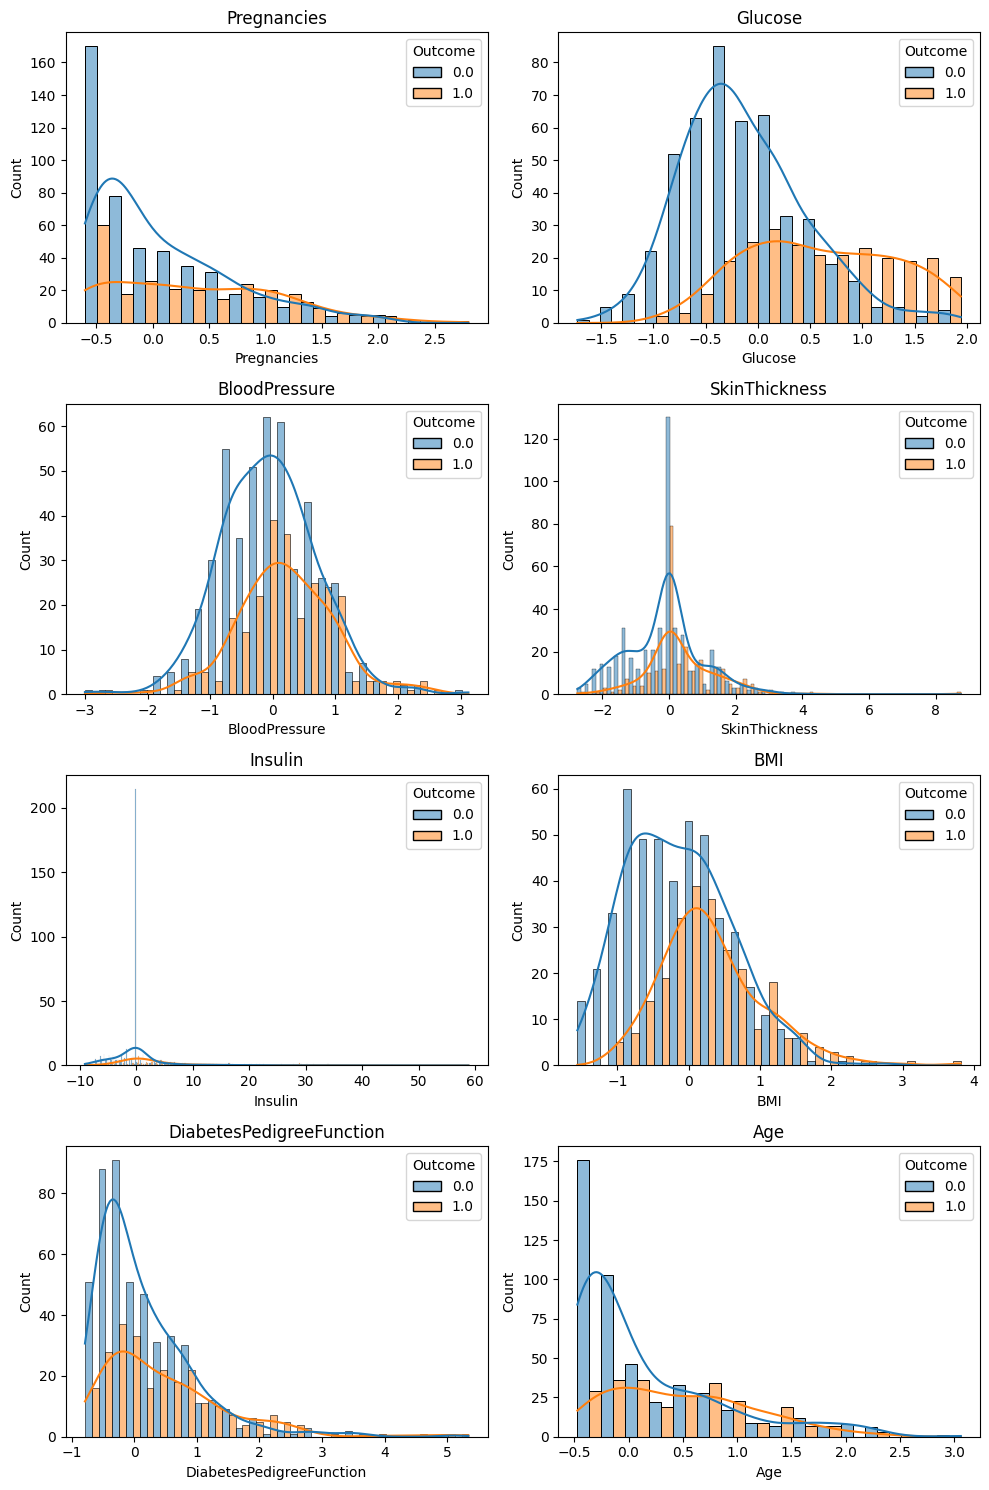

In [23]:
# Seleccinamos las columnas a graficar
columnas = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Creamos hisplot para cada una
fig, axes = plt.subplots(4, 2, figsize=(10, 15))
axes = axes.flatten()  # Convertimos los ejes en una lista plana para iterar

# Iteramos por cada columna del dataframe
for i, columna in enumerate(columnas):
    sns.histplot(ax=axes[i], x=columna, data=df1, hue='Outcome', kde=True, multiple='dodge')  
    axes[i].set_title(columna)

# Para mostrar el gráfico
plt.tight_layout()
plt.show()

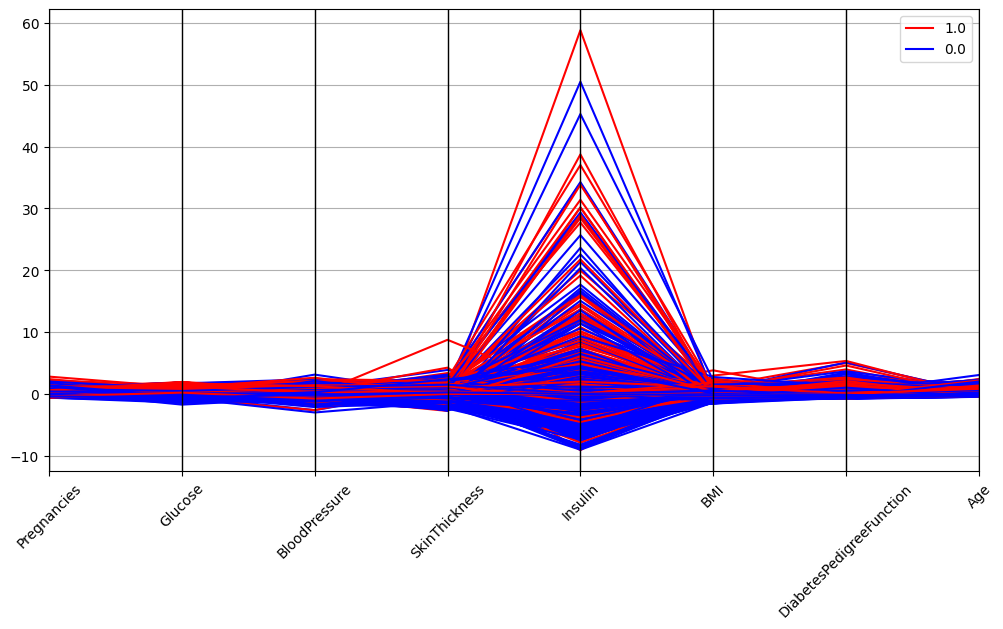

In [24]:
# Creamos un gráfico de coordenadas paralelas para visualizar las características escaladas
plt.figure(figsize=(12, 6))
pd.plotting.parallel_coordinates(df1, 'Outcome', color=['red', 'blue'])
plt.xticks(rotation=45)
plt.show()

# Datos de Entrenamiento y de Prueba

In [25]:
X = df1.drop("Outcome", axis=1)
y = df1["Outcome"]

In [26]:
# División de Datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo de Árbol de Decisión

In [27]:
# Creamos el árbol de decisión
modelo_tree = DecisionTreeClassifier(class_weight='balanced', random_state=42,)
modelo_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [28]:
# Creamos un DataFrame con la importancia de las características
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': modelo_tree.feature_importances_
}).sort_values(by='Importance', ascending=False)

In [29]:
# Visualizamos la importancia de las características
print(feature_importance)

                    Feature  Importance
1                   Glucose    0.258601
5                       BMI    0.199819
7                       Age    0.132898
4                   Insulin    0.108584
6  DiabetesPedigreeFunction    0.097231
0               Pregnancies    0.073654
2             BloodPressure    0.067646
3             SkinThickness    0.061567


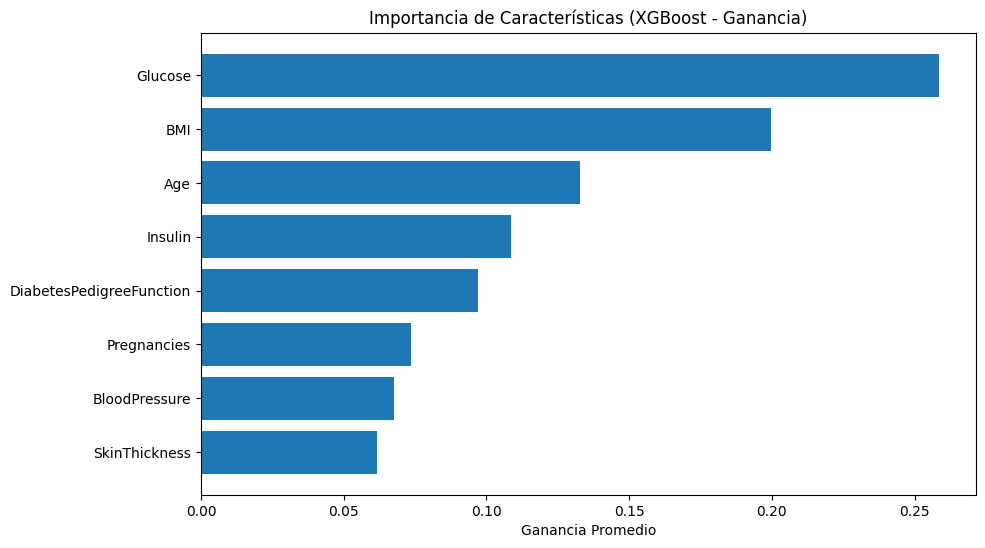

In [30]:
# Gràfica de la importancia de las características
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Importancia de Características (XGBoost - Ganancia)')
plt.xlabel('Ganancia Promedio')
plt.gca().invert_yaxis()  # Mostrar la característica más importante arriba
plt.show()

In [31]:
# Predicciones con modelo inicial
y_pred = modelo_tree.predict(X_test)
print("Métricas con todas las variables:")
print(classification_report(y_test, y_pred))

Métricas con todas las variables:
              precision    recall  f1-score   support

         0.0       0.85      0.80      0.83       102
         1.0       0.59      0.67      0.63        43

    accuracy                           0.77       145
   macro avg       0.72      0.74      0.73       145
weighted avg       0.78      0.77      0.77       145



In [32]:
# Discriminación de variables seleccionadas
variables_seleccionadas = [
    'Glucose',
    'BMI',
    'Age',
    'Insulin',
    'DiabetesPedigreeFunction',
    'Pregnancies',
    'BloodPressure']

In [33]:
# Modelo con variables seleccionadas
modelo_tree_selecto = DecisionTreeClassifier(class_weight='balanced', random_state=42)
modelo_tree_selecto.fit(X_train[variables_seleccionadas], y_train)

# Predicciones con variables seleccionadas
y_pred_selecto = modelo_tree_selecto.predict(X_test[variables_seleccionadas])

print("Métricas con variables seleccionadas:")
print(classification_report(y_test, y_pred_selecto))

Métricas con variables seleccionadas:
              precision    recall  f1-score   support

         0.0       0.84      0.81      0.83       102
         1.0       0.59      0.63      0.61        43

    accuracy                           0.76       145
   macro avg       0.71      0.72      0.72       145
weighted avg       0.76      0.76      0.76       145



Ambos modelos tienen un desempeño aceptable pero mejorable, especialmente para la clase minoritaria. La elección entre variables seleccionadas o todas depende del equilibrio deseado entre interpretabilidad y precisión. Para un modelo clínicamente útil, se debe prioriza mejorar el recall de la clase 1 (diabetes)

# Hiperparámetros

Como se empleará todos los datos se buscará los hiperparámetros del modelo

In [34]:
# hiperparámetros a probar
param_grid = {
    "max_depth": [10, 15, 20, 25, None],    # Profundidades diferentes
    "min_samples_leaf": [5, 10, 15, 20],    # Mínimo de muestras por hoja
    "ccp_alpha": [0.0, 0.01, 0.05, 0.1],    # Poda del árbol
    "criterion": ["gini", "entropy"],       # Métrica de división
    "splitter": ["best", "random"],         # Estrategia de división
    "max_features": ["sqrt", "log2", None]  # Número de características consideradas
}

# Optimización con GridSearchCV
grid_search = GridSearchCV(
    modelo_tree, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'ccp_alpha': [0.0, 0.01, 0.05, 0.1],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20, 25, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [5, 10, 15, 20],
                         'splitter': ['best', 'random']},
             scoring='accuracy', verbose=1)

In [35]:
# Mostrar los mejores parámetros encontrados
print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)


Mejores parámetros encontrados:
{'ccp_alpha': 0.01, 'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 20, 'splitter': 'best'}


In [36]:
# El mejor modelo con parámetros encontrados

best_model = grid_search.best_estimator_

In [37]:
# Aplicamos al árbol los datos de entrenamiento y de test

train_pred = best_model.predict(X_train)
test_pred = best_model.predict(X_test)

# Métricas de Evaluación

In [38]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

In [39]:
print(get_metrics(y_train, y_test, train_pred, test_pred))

            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.787565  0.723596  0.786219   0.673640  0.781553     0.790885
Test        0.793103  0.711538  0.812585   0.606557  0.860465     0.764706
Diferencia -0.005539  0.012057 -0.026366   0.067083 -0.078912     0.026179


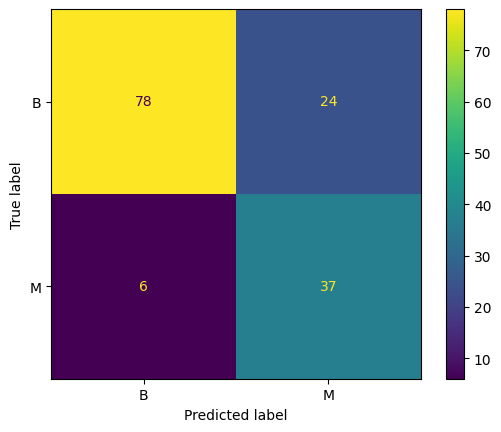

In [40]:
# Matriz de Confusión
cm = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['B', 'M'])
disp.plot()

In [41]:
# Evaluación en test
y_pred_best = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_best)
print(f"\nAccuracy en el conjunto de prueba: {accuracy:.4f}")

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_best))


Accuracy en el conjunto de prueba: 0.7931

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.93      0.76      0.84       102
         1.0       0.61      0.86      0.71        43

    accuracy                           0.79       145
   macro avg       0.77      0.81      0.78       145
weighted avg       0.83      0.79      0.80       145



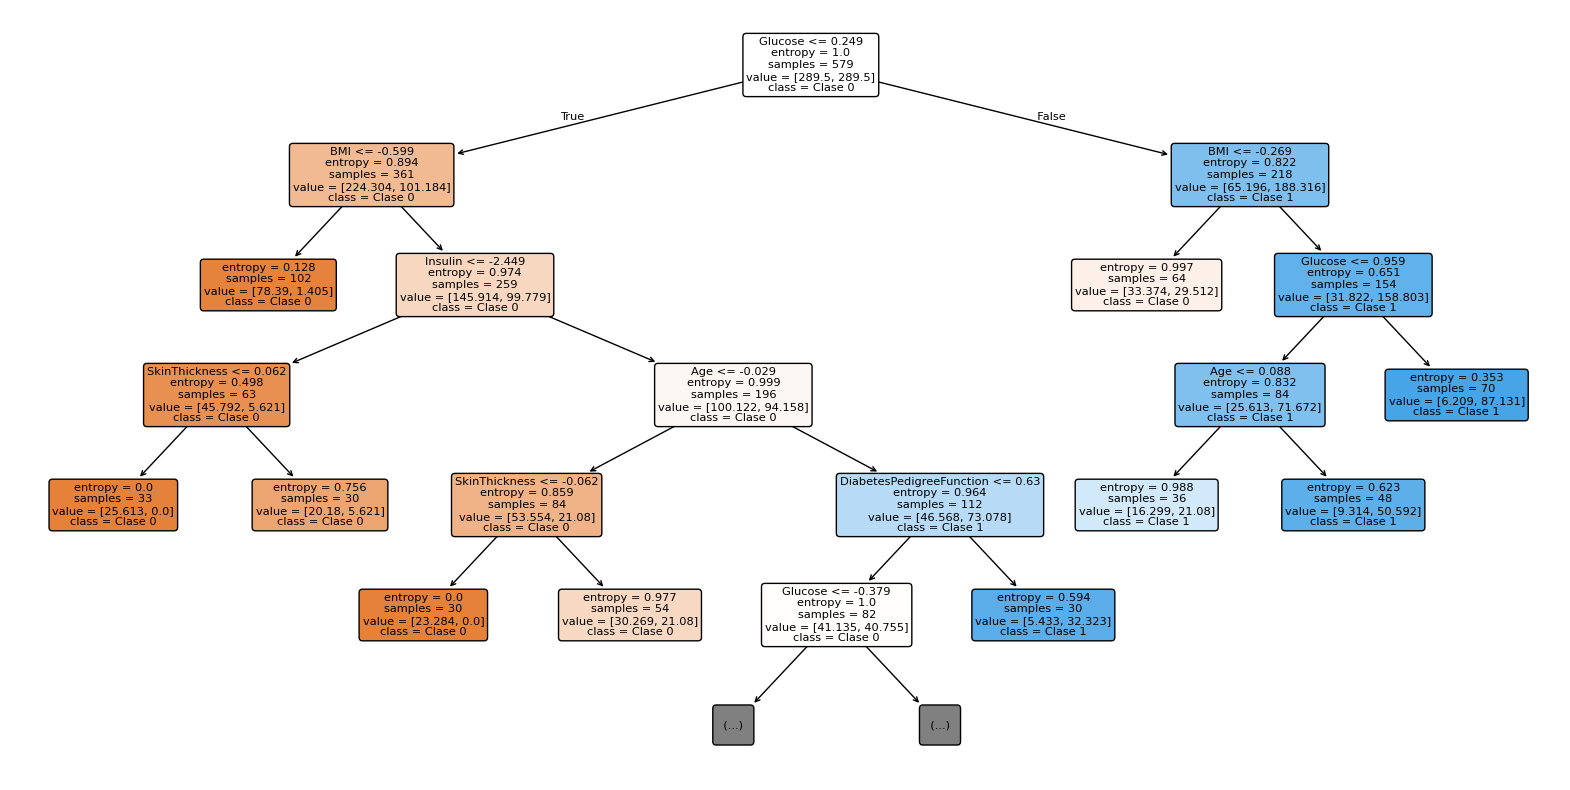

In [42]:
# Diagrama del Árbol de Decisión creado
plt.figure(figsize=(20, 10))
plot_tree(
    best_model,
    feature_names=X_train.columns,  # Nombres de las características
    class_names=['Clase 0', 'Clase 1'],  # Nombres de las clases
    filled=True,
    rounded=True,
    max_depth=5  # Limitar la profundidad para visualización
)
plt.show()

# Save los archivos

In [43]:
# Convertir los arrays numpy escalados a DataFrames de pandas
X_train = pd.DataFrame(X_train, columns=X_train.columns)
X_test = pd.DataFrame(X_test, columns=X_test.columns)

# Añadir la columna 'y' a los DataFrames escalados
X_train["y"] = y_train.values
X_test["y"] = y_test.values

# Guardamos los archivos
X_train.to_csv("../data/processed/clean_train.csv", index = False)
X_test.to_csv("../data/processed/clean_test.csv", index = False)

In [44]:
# Guardamos el modelo
from pickle import dump

dump(best_model, open("../models/ArboldeDecision.sav", "wb"))

# Conclusiones

El modelo optimizado es un avance significativo en detección de diabetes (alta sensibilidad), pero requiere refinamiento para reducir falsos positivos y validación en contextos clínicos reales.